In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

Actualizando dataset...
Dataset already up to date.
El dataset ya estaba actualizado
Última actualización: 2025-05-08 18:44:19


In [3]:
# Usar el dataset ya actualizado o cargarlo si no se actualizó
if 'df_updated' in locals() and df_updated is not None:
    df = df_updated
    print("Usando dataset recién actualizado")
else:
    df = pd.read_csv('data/merged_data.csv')
    print("Cargando dataset desde archivo")

Usando dataset recién actualizado


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   close_btc         1305 non-null   float64       
 1   volume_btc        1305 non-null   float64       
 2   date              1305 non-null   datetime64[ns]
 3   close_WTI         1305 non-null   float64       
 4   volume_oil        1305 non-null   float64       
 5   close_VIX         1305 non-null   float64       
 6   close_cpi         1305 non-null   float64       
 7   close_int         1305 non-null   float64       
 8   close_qqq         1305 non-null   float64       
 9   volume_qqq        1305 non-null   float64       
 10  difficulty        1305 non-null   float64       
 11  hash_rate         1305 non-null   float64       
 12  value_fear_greed  1305 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 132.7 KB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df['target'] = df['close_btc'].shift(-1)  

df['target_signal'] = df.apply(lambda row: 'verde' if row['target'] > row['close_btc'] * 1.005 
                                             else ('rojo' if row['target'] < row['close_btc'] * 0.995
                                                   else 'amarillo'), axis=1)

# Eliminamos la última fila que tiene target NaN
df = df.dropna(subset=['target'])



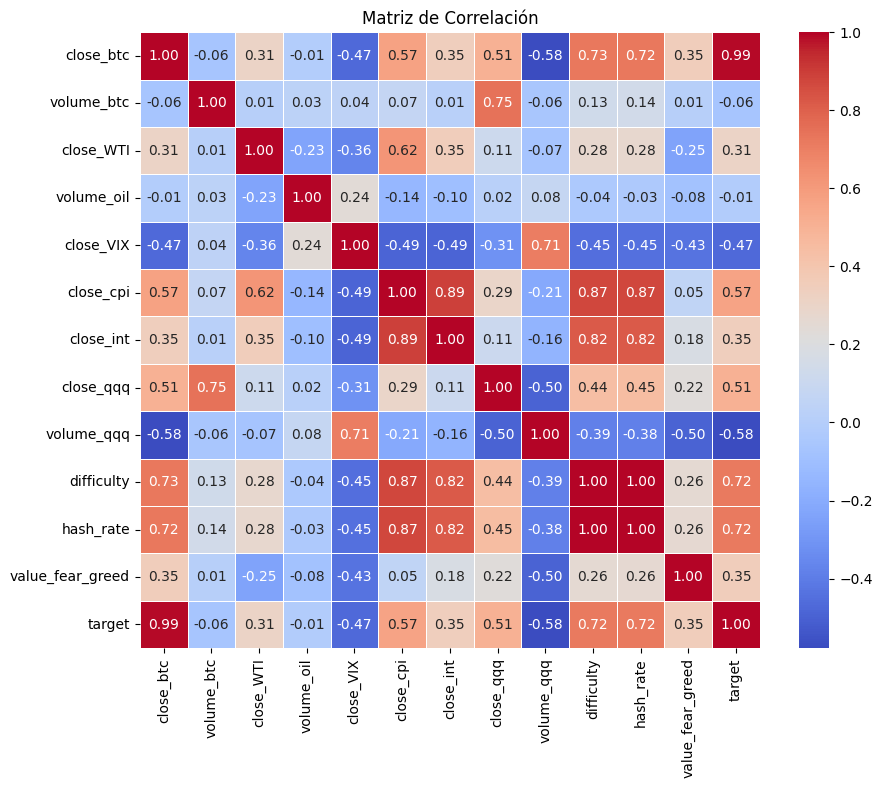

In [6]:
corr_matrix = df.drop(columns=['date', 'target_signal'], errors='ignore').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()



DataFrame original: (1304, 15)
DataFrame seleccionado: (1304, 10)


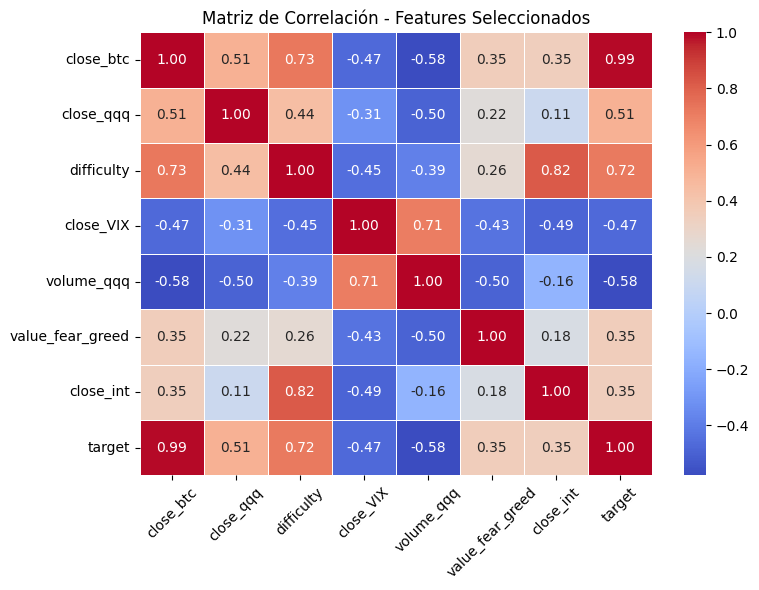


Primeras filas del DataFrame con features seleccionados:


,close_btc,close_qqq,difficulty,close_VIX,volume_qqq,value_fear_greed,close_int,date,target,target_signal
0,69670.0,22.71,1.379878e+13,12.47,65720000.0,39.0,1.55,2020-01-02,73431.0,verde
1,73431.0,22.09,1.379878e+13,14.02,72660000.0,38.0,1.55,2020-01-03,77591.0,verde
2,77591.0,22.51,1.379878e+13,13.85,64390000.0,41.0,1.55,2020-01-06,81557.0,verde
3,81557.0,22.49,1.379878e+13,13.79,57530000.0,40.0,1.55,2020-01-07,80596.0,rojo
4,80596.0,23.00,1.379878e+13,13.45,80130000.0,51.0,1.55,2020-01-08,78424.0,rojo


In [7]:
selected_features = ['close_btc', 'close_qqq', 'difficulty', 'close_VIX', 'volume_qqq', 'value_fear_greed', 'close_int']

df_selected = df[selected_features + ['date', 'target', 'target_signal']]
print(f"DataFrame original: {df.shape}")
print(f"DataFrame seleccionado: {df_selected.shape}")

corr_selected = df_selected.drop(columns=['date', 'target_signal'], errors='ignore').corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_selected, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación - Features Seleccionados')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPrimeras filas del DataFrame con features seleccionados:")
df_selected.head()

In [8]:
selected_features = ['close_btc', 'close_qqq', 'difficulty', 'close_VIX', 'volume_qqq']

df_selected['btc_change'] = df_selected['close_btc'].pct_change()

df_selected = df_selected.dropna()

X = df_selected[selected_features + ['btc_change']]  
y = df_selected['target_signal']  
dates = df_selected['date']  

train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
dates_train, dates_test = dates.iloc[:train_size], dates.iloc[train_size:]

print(f"Features utilizados: {X.columns.tolist()}")
print(f"Tamaño conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño conjunto de prueba: {X_test.shape}")

Features utilizados: ['close_btc', 'close_qqq', 'difficulty', 'close_VIX', 'volume_qqq', 'btc_change']
Tamaño conjunto de entrenamiento: (1042, 6)
Tamaño conjunto de prueba: (261, 6)


/var/folders/9d/njcmv3bs67bgg_6p6s5pyjsw0000gn/T/ipykernel_5280/2066865382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['btc_change'] = df_selected['close_btc'].pct_change()


In [9]:
# 2. Preprocesamiento y modelado con pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# # Crear pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Normalizar todas las características
#     ('pca', PCA(n_components=0.90)),  # Conservar componentes que expliquen 95% de varianza
#     ('classifier', RandomForestClassifier(random_state=42))  # Clasificador
# ])

# # Entrenar el pipeline
# pipeline.fit(X_train, y_train)

# # Evaluar el modelo
# y_pred = pipeline.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# conf_matrix = confusion_matrix(y_test, y_pred)

# print(f"Exactitud del modelo: {accuracy:.4f}")
# print("\nMatriz de confusión:")
# print(conf_matrix)

# # Ver importancia de componentes PCA
# pca = pipeline.named_steps['pca']
# print(f"\nNúmero de componentes PCA seleccionados: {pca.n_components_}")
# print(f"Varianza explicada: {sum(pca.explained_variance_ratio_):.4f}")


In [10]:
# EVALUACIÓN DE MÚLTIPLES MODELOS
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

# Lista de modelos a evaluar
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'SVC': SVC(class_weight='balanced', random_state=42),
    'LogisticRegression': LogisticRegression(multi_class='multinomial', 
                                             class_weight='balanced',
                                             max_iter=2000,
                                             random_state=42)
}

# Almacenará los resultados
results = {}

# Evaluar cada modelo
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluando modelo: {name}")
    print(f"{'='*50}")
    
    # Crear pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.90)),
        ('classifier', model)
    ])
    
    # Entrenar el pipeline
    pipeline.fit(X_train, y_train)
    
    # Evaluar el modelo
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Guardar resultados
    results[name] = {
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'pipeline': pipeline,
        'predictions': y_pred
    }
    
    print(f"Exactitud del modelo: {accuracy:.4f}")
    print("\nMatriz de confusión:")
    print(conf_matrix)
    
    # Ver importancia de componentes PCA
    pca = pipeline.named_steps['pca']
    print(f"\nNúmero de componentes PCA seleccionados: {pca.n_components_}")
    print(f"Varianza explicada: {sum(pca.explained_variance_ratio_):.4f}")

# Mostrar resumen de todos los modelos
print("\n\n" + "="*70)
print("RESUMEN DE RESULTADOS")
print("="*70)
for name, res in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"{name}: {res['accuracy']:.4f}")

# Cambiar la selección automática por la selección manual de RandomForest
# best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model_name = 'RandomForest'  # Selección manual del modelo que generaliza mejor

print(f"\nModelo seleccionado: {best_model_name} con exactitud: {results[best_model_name]['accuracy']:.4f}")
print("(Seleccionado por tener la matriz de confusión más balanceada en lugar del máximo accuracy)")

# Usar las predicciones del modelo seleccionado para la visualización final
y_pred = results[best_model_name]['predictions']
conf_matrix = results[best_model_name]['conf_matrix']

print("\nMatriz de confusión del modelo seleccionado (RandomForest):")
print(conf_matrix)


Evaluando modelo: RandomForest
Exactitud del modelo: 0.4291

Matriz de confusión:
[[ 0  6 28]
 [ 0 18 99]
 [ 0 16 94]]

Número de componentes PCA seleccionados: 4
Varianza explicada: 0.9440

Evaluando modelo: GradientBoosting
Exactitud del modelo: 0.4713

Matriz de confusión:
[[ 0 18 16]
 [ 0 60 57]
 [ 1 46 63]]

Número de componentes PCA seleccionados: 4
Varianza explicada: 0.9440

Evaluando modelo: AdaBoost
Exactitud del modelo: 0.4866

Matriz de confusión:
[[ 0 10 24]
 [ 0 44 73]
 [ 0 27 83]]

Número de componentes PCA seleccionados: 4
Varianza explicada: 0.9440

Evaluando modelo: SVC
Exactitud del modelo: 0.3755

Matriz de confusión:
[[ 2  3 29]
 [23  2 92]
 [14  2 94]]

Número de componentes PCA seleccionados: 4
Varianza explicada: 0.9440

Evaluando modelo: LogisticRegression
Exactitud del modelo: 0.2682

Matriz de confusión:
[[16 17  1]
 [64 53  0]
 [63 46  1]]

Número de componentes PCA seleccionados: 4
Varianza explicada: 0.9440


RESUMEN DE RESULTADOS
AdaBoost: 0.4866
Gradien

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


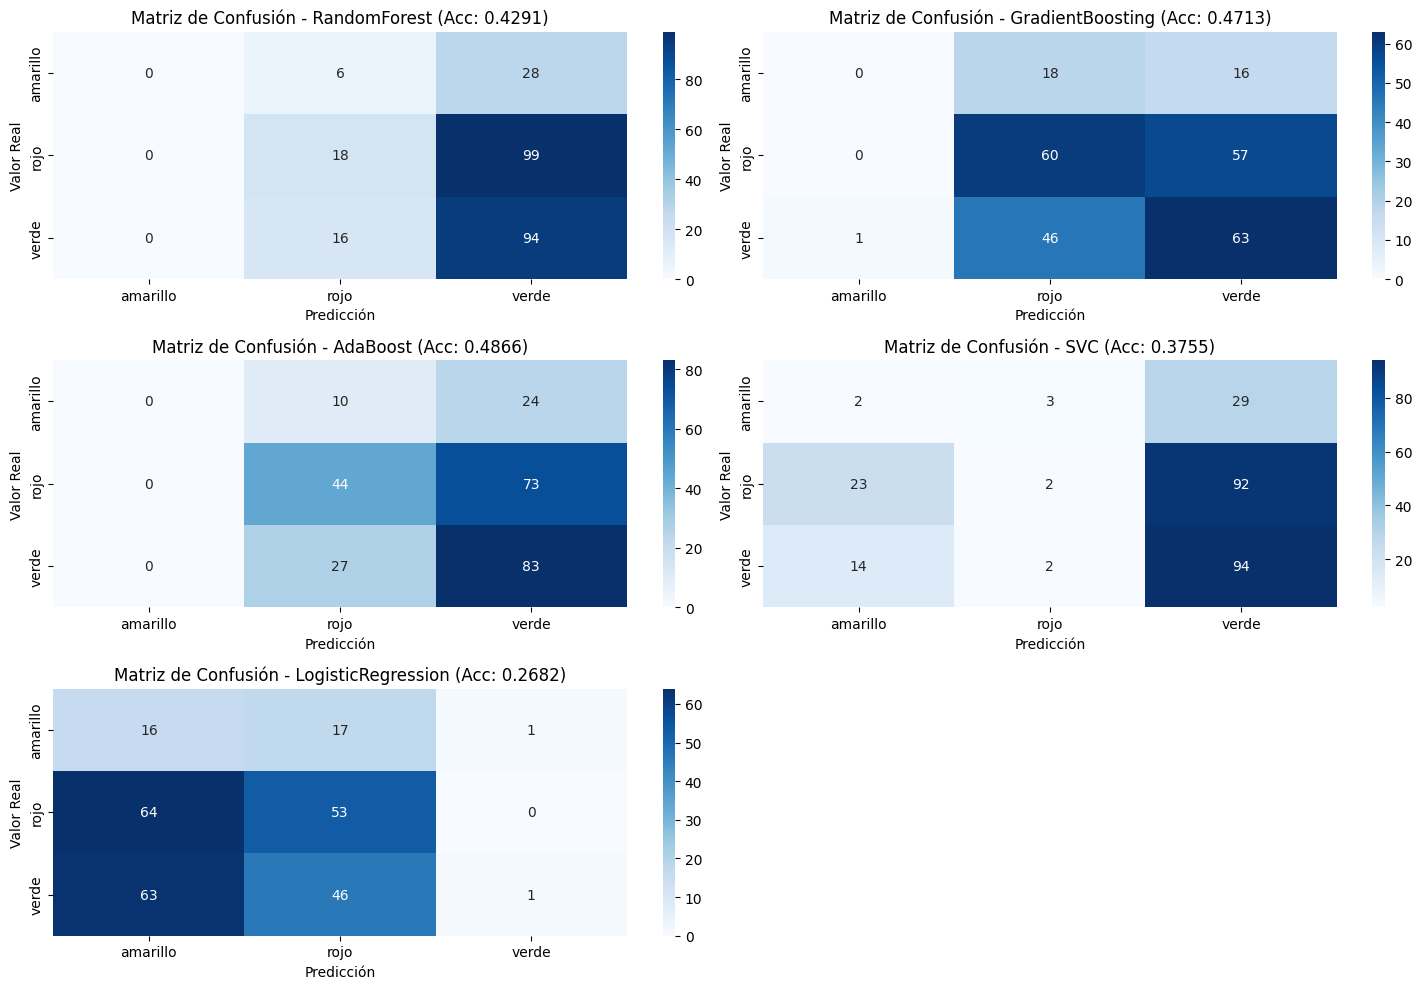

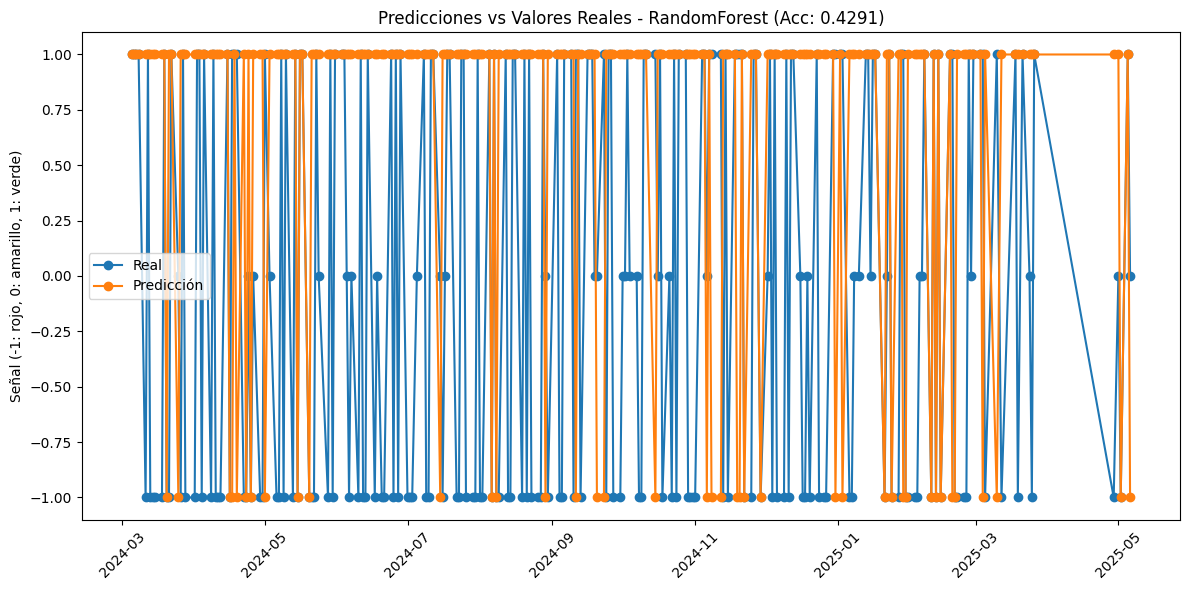


Informe de clasificación detallado - RandomForest:
              precision    recall  f1-score   support

    amarillo       0.00      0.00      0.00        34
        rojo       0.45      0.15      0.23       117
       verde       0.43      0.85      0.57       110

    accuracy                           0.43       261
   macro avg       0.29      0.34      0.27       261
weighted avg       0.38      0.43      0.34       261



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

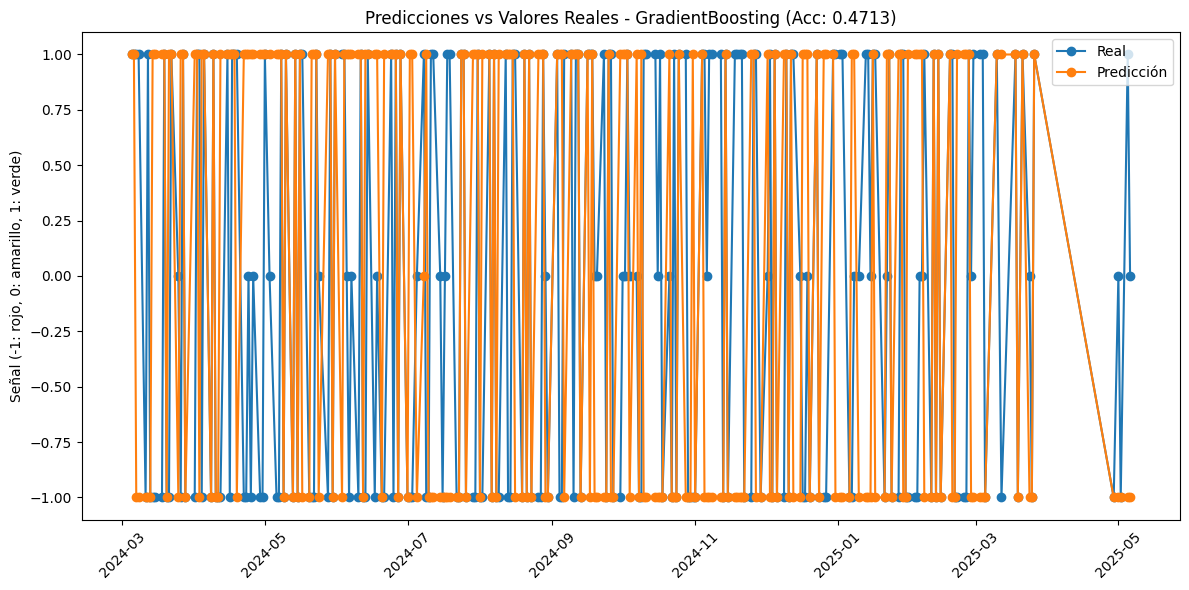


Informe de clasificación detallado - GradientBoosting:
              precision    recall  f1-score   support

    amarillo       0.00      0.00      0.00        34
        rojo       0.48      0.51      0.50       117
       verde       0.46      0.57      0.51       110

    accuracy                           0.47       261
   macro avg       0.32      0.36      0.34       261
weighted avg       0.41      0.47      0.44       261



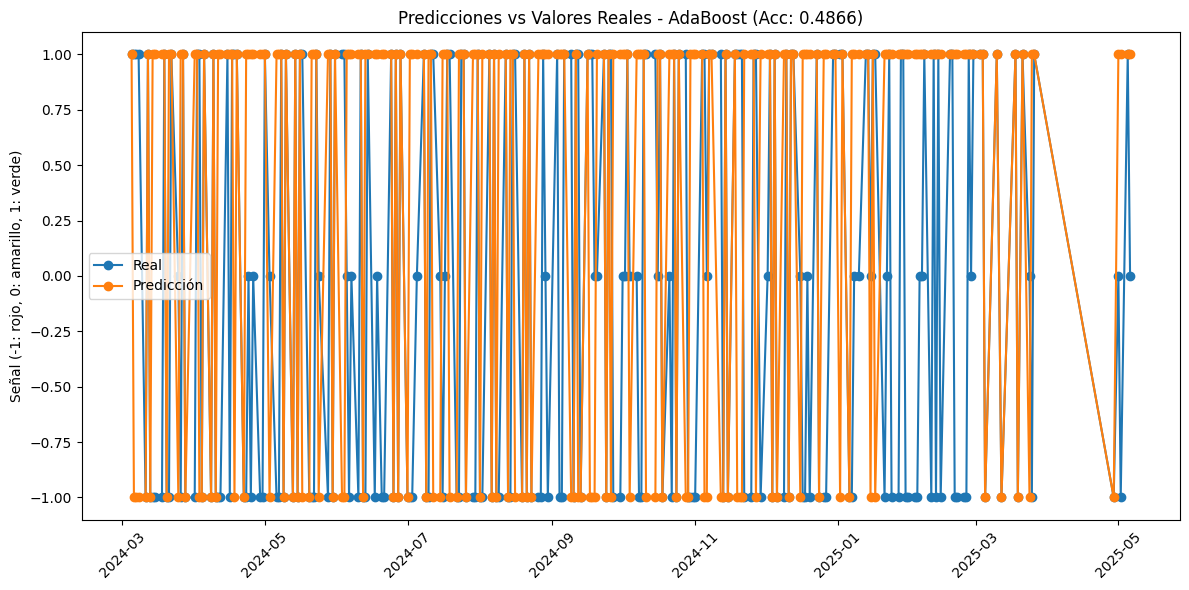


Informe de clasificación detallado - AdaBoost:
              precision    recall  f1-score   support

    amarillo       0.00      0.00      0.00        34
        rojo       0.54      0.38      0.44       117
       verde       0.46      0.75      0.57       110

    accuracy                           0.49       261
   macro avg       0.33      0.38      0.34       261
weighted avg       0.44      0.49      0.44       261



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

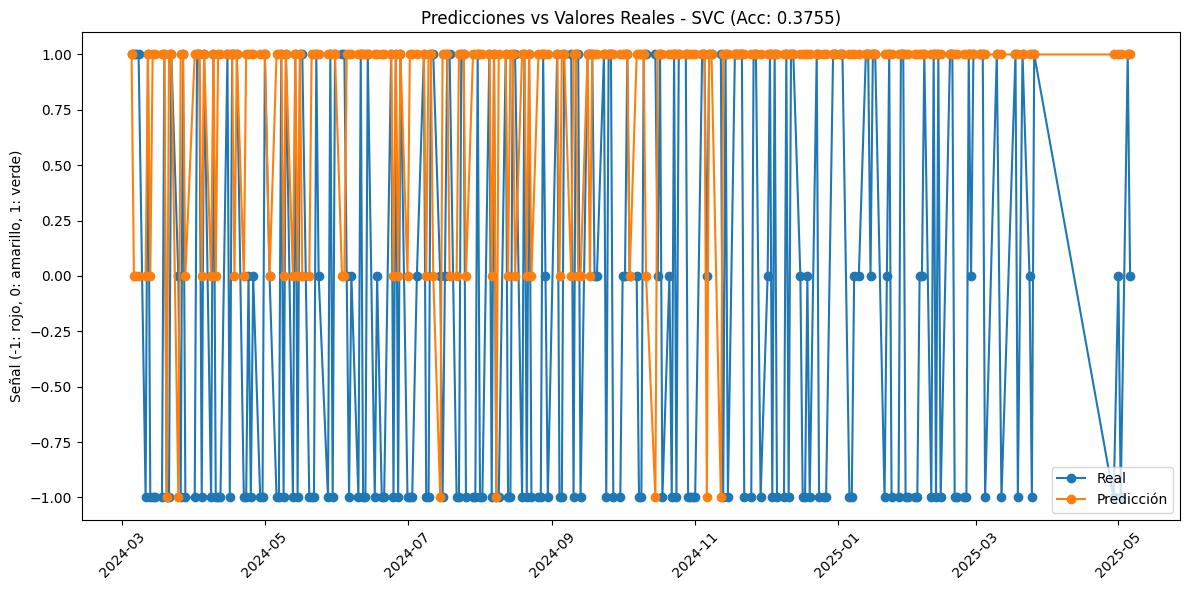


Informe de clasificación detallado - SVC:
              precision    recall  f1-score   support

    amarillo       0.05      0.06      0.05        34
        rojo       0.29      0.02      0.03       117
       verde       0.44      0.85      0.58       110

    accuracy                           0.38       261
   macro avg       0.26      0.31      0.22       261
weighted avg       0.32      0.38      0.27       261



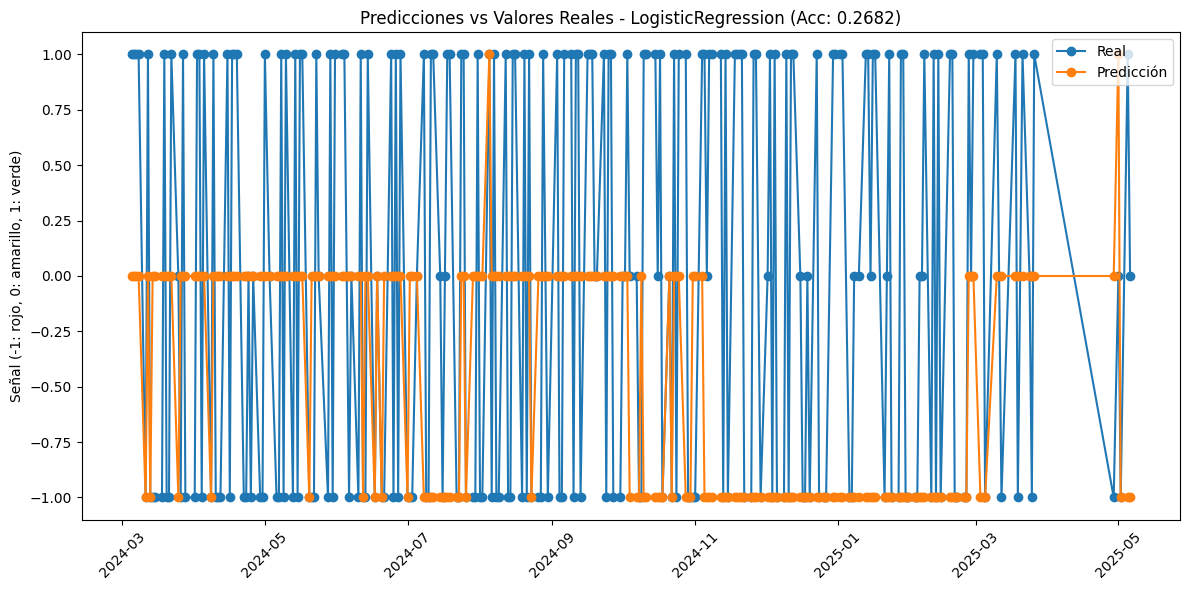


Informe de clasificación detallado - LogisticRegression:
              precision    recall  f1-score   support

    amarillo       0.11      0.47      0.18        34
        rojo       0.46      0.45      0.45       117
       verde       0.50      0.01      0.02       110

    accuracy                           0.27       261
   macro avg       0.36      0.31      0.22       261
weighted avg       0.43      0.27      0.24       261



In [11]:
# 3. Visualizar los resultados de TODOS los modelos
from sklearn.metrics import classification_report

# Visualizar matrices de confusión para todos los modelos
plt.figure(figsize=(15, 10))
num_models = len(results)
rows = (num_models + 1) // 2  # Redondear hacia arriba para obtener el número de filas

for i, (name, res) in enumerate(results.items()):
    plt.subplot(rows, 2, i+1)
    sns.heatmap(res['conf_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=sorted(y.unique()), 
                yticklabels=sorted(y.unique()))
    plt.title(f'Matriz de Confusión - {name} (Acc: {res["accuracy"]:.4f})')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.tight_layout()
plt.show()

# Graficar predicciones vs valores reales a lo largo del tiempo para cada modelo
for name, res in results.items():
    results_df = pd.DataFrame({
        'date': dates_test.reset_index(drop=True),
        'real': y_test.reset_index(drop=True),
        'prediccion': res['predictions']
    })
    
    # Codificar colores para visualización
    color_map = {'verde': 1, 'amarillo': 0, 'rojo': -1}
    results_df['real_num'] = results_df['real'].map(color_map)
    results_df['pred_num'] = results_df['prediccion'].map(color_map)
    
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['date'], results_df['real_num'], 'o-', label='Real')
    plt.plot(results_df['date'], results_df['pred_num'], 'o-', label='Predicción')
    plt.title(f'Predicciones vs Valores Reales - {name} (Acc: {res["accuracy"]:.4f})')
    plt.ylabel('Señal (-1: rojo, 0: amarillo, 1: verde)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Mostrar informe de clasificación
    print(f"\nInforme de clasificación detallado - {name}:")
    print(classification_report(y_test, res['predictions']))
    print("="*80)


Realizando análisis de backtest...

Estadísticas de rendimiento:
               Modelo  Exactitud  Retorno Total (%)  Retorno Medio Diario (%)  \
0        RandomForest   0.429119         -82.856675                 -0.087060   
1    GradientBoosting   0.471264         -94.135177                 -0.496808   
2            AdaBoost   0.486590         -91.540671                 -0.357221   
3                 SVC   0.375479         -84.971344                 -0.147670   
4  LogisticRegression   0.268199         -20.917390                 -0.064100   
5          Buy & Hold        NaN         -84.789408                 -0.132452   

   Volatilidad Diaria (%)  Ratio Sharpe  Max Drawdown (%)  
0                6.561177     -0.210638         90.167197  
1                6.542775     -1.205388         95.803149  
2                6.551989     -0.865494         93.452002  
3                6.395490     -0.366537         91.074741  
4                2.254043     -0.451437         41.740636  
5     

/var/folders/9d/njcmv3bs67bgg_6p6s5pyjsw0000gn/T/ipykernel_5280/4281226693.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  backtest_results[f'{name}_position'].fillna(0, inplace=True)
/var/folders/9d/njcmv3bs67bgg_6p6s5pyjsw0000gn/T/ipykernel_5280/4281226693.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

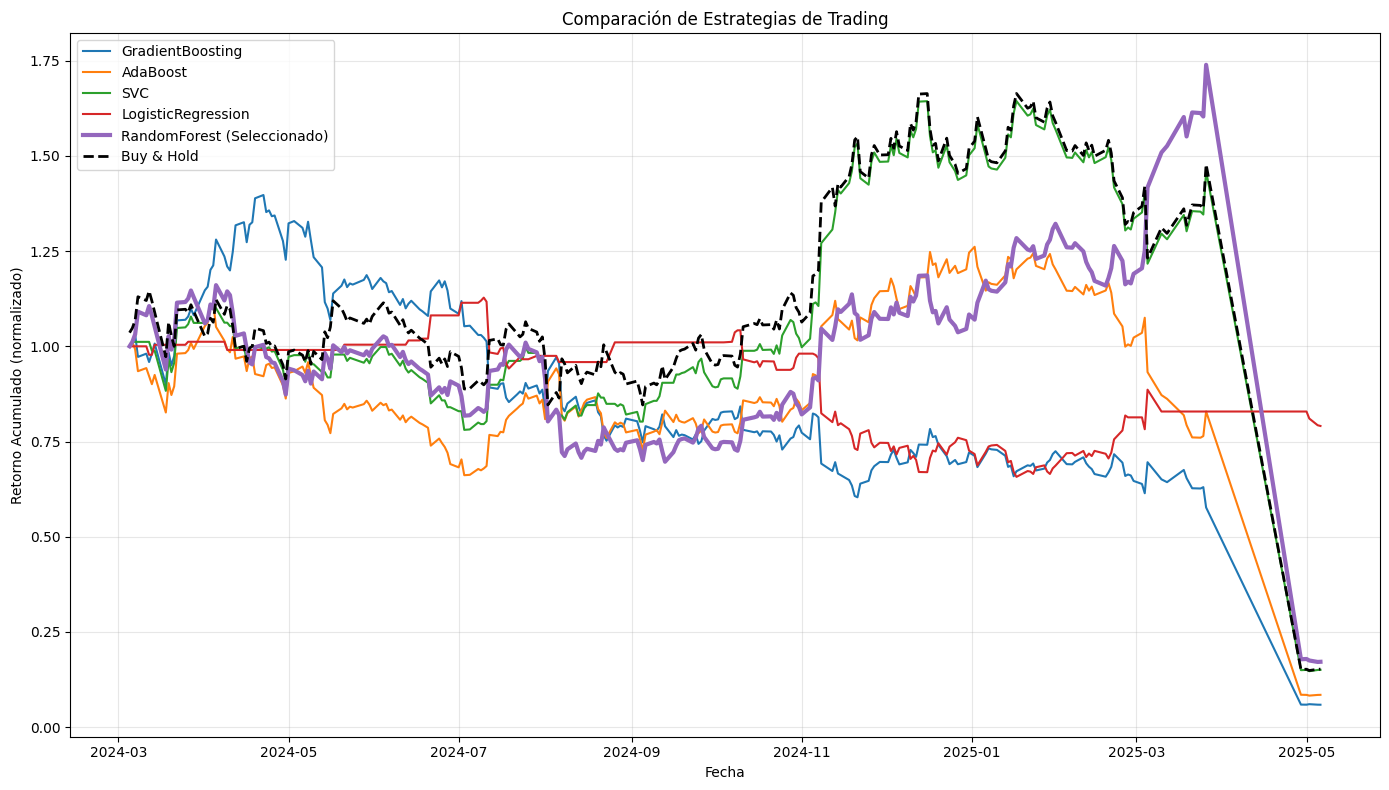

In [12]:
# 4. ANÁLISIS DE BACKTEST (RENTABILIDAD)
print("\nRealizando análisis de backtest...")

# Crear DataFrame para backtest
backtest_results = pd.DataFrame({
    'date': dates_test.reset_index(drop=True),
    'close': X_test['close_btc'].reset_index(drop=True)
})

# Calcular rendimiento real del día siguiente (ya lo tenemos en el target)
backtest_results['actual_return'] = df_selected.loc[X_test.index, 'target'].reset_index(drop=True) / backtest_results['close'] - 1

# Mapear las etiquetas de clasificación a señales de trading
strategy_map = {'verde': 1, 'amarillo': 0, 'rojo': -1}

# Calcular estrategia para cada modelo
for name, res in results.items():
    # Convertir predicciones a valores de estrategia (-1, 0, 1)
    # Primero convertimos el array de NumPy a una serie de pandas
    predictions_series = pd.Series(res['predictions'])
    backtest_results[f'{name}_pred'] = predictions_series.map(strategy_map)
    
    # Calcular posición basada en predicción del día anterior
    backtest_results[f'{name}_position'] = backtest_results[f'{name}_pred'].shift(1)
    backtest_results[f'{name}_position'].fillna(0, inplace=True)
    
    # Calcular retornos de la estrategia
    backtest_results[f'{name}_return'] = backtest_results[f'{name}_position'] * backtest_results['actual_return']
    
    # Calcular retorno acumulado
    backtest_results[f'{name}_cumulative'] = (1 + backtest_results[f'{name}_return']).cumprod()

# Calcular Buy & Hold como benchmark
backtest_results['BuyHold_cumulative'] = (1 + backtest_results['actual_return']).cumprod()

# Visualizar resultados de backtest
plt.figure(figsize=(14, 8))

# Graficar cada modelo (excepto el seleccionado, que se graficará después)
for name in results.keys():
    if name != best_model_name:  # Solo graficar los que no son el modelo seleccionado
        plt.plot(backtest_results['date'], 
                 backtest_results[f'{name}_cumulative'], 
                 label=f"{name}")

# Destacar el modelo seleccionado con línea más gruesa
plt.plot(backtest_results['date'], 
         backtest_results[f'{best_model_name}_cumulative'], 
         linewidth=3,
         label=f"{best_model_name} (Seleccionado)")

# Graficar Buy & Hold
plt.plot(backtest_results['date'], 
         backtest_results['BuyHold_cumulative'], 
         'k--', linewidth=2, label='Buy & Hold')

plt.title('Comparación de Estrategias de Trading')
plt.xlabel('Fecha')
plt.ylabel('Retorno Acumulado (normalizado)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('backtest_comparison.png')

# Análisis estadístico final
model_stats = []

for name in results.keys():
    returns = backtest_results[f'{name}_return'].dropna()
    
    stats = {
        'Modelo': name,
        'Exactitud': results[name]['accuracy'],
        'Retorno Total (%)': (backtest_results[f'{name}_cumulative'].iloc[-1] - 1) * 100,
        'Retorno Medio Diario (%)': returns.mean() * 100,
        'Volatilidad Diaria (%)': returns.std() * 100,
        'Ratio Sharpe': (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0,
        'Max Drawdown (%)': (1 - (backtest_results[f'{name}_cumulative'] / 
                           backtest_results[f'{name}_cumulative'].cummax())).max() * 100
    }
    model_stats.append(stats)

# Añadir Buy & Hold como benchmark
buyhold_returns = backtest_results['actual_return'].dropna()
buyhold_stats = {
    'Modelo': 'Buy & Hold',
    'Exactitud': np.nan,
    'Retorno Total (%)': (backtest_results['BuyHold_cumulative'].iloc[-1] - 1) * 100,
    'Retorno Medio Diario (%)': buyhold_returns.mean() * 100,
    'Volatilidad Diaria (%)': buyhold_returns.std() * 100,
    'Ratio Sharpe': (buyhold_returns.mean() / buyhold_returns.std()) * np.sqrt(252) if buyhold_returns.std() > 0 else 0,
    'Max Drawdown (%)': (1 - (backtest_results['BuyHold_cumulative'] / 
                       backtest_results['BuyHold_cumulative'].cummax())).max() * 100
}
model_stats.append(buyhold_stats)

# Crear DataFrame con estadísticas
stats_df = pd.DataFrame(model_stats)
print("\nEstadísticas de rendimiento:")
print(stats_df)

print("\nAnálisis de backtest guardado como 'backtest_comparison.png'")

In [13]:
import pickle

best_model = results['RandomForest']['pipeline']
with open('model/randomforest.pkl', 'wb') as file:
    pickle.dump(best_model, file)

df_selected.to_csv('data/df_selected.csv', index=False)